## Breast Cancer Dataset: Tutorial and Examples

### **Imports**

In [5]:
import pandas as pd
import numpy as np

from mlbugdetection.load_data import load_dataset
from mlbugdetection.monotonic import monotonicity_mse, check_monotonicity_single_sample, check_monotonicity_multiple_samples
from mlbugdetection.critical_values import highest_and_lowest_indexes, find_critical_values, find_several_critical_values
from mlbugdetection.calibration import calibration_check
from mlbugdetection.sanity import sanity_check, sanity_check_with_indexes

### **Load Data**
#### First, divide the data into the categories of malignant and benign tumors

In [6]:
df = load_dataset()
df.head(5)

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [7]:
mal = df[df.diagnosis == "M"]
ben = df[df.diagnosis == "B"]

In [8]:
X_ben = ben.drop(columns=["diagnosis"])
X_ben.drop('id', axis=1, inplace=True) #drop redundant columns
X_mal = mal.drop(columns=["diagnosis"])
X_mal.drop('id', axis=1, inplace=True) #drop redundant columns

In [9]:
sample_ben = X_ben.sample(1, random_state=42)
sample_mal = X_mal.sample(1, random_state=23)


### Load the trained models that will be analyzed

In [10]:
model_path_lg = "models/LogisticRegression/LGBreastCancer.pkl"
model_path_knn = "models/KNN/KNNBreastCancer.pkl"
model_path_xg = "models/XGBoost/XGBoostBreastCancer.pkl"

### **Monotonicity analysis**
#### The monotonicity analysis module has two main functions: *check_monotonicity_single_sample* and *check_monotonicity_multiple_samples*.
#### The function *check_monotonicity_single_sample* receives a model, a single sample (one dataframe row), the feature that will be analyzed, the value interval of this feature, and the number of points analysed between this interval
#### The graph bellow shows that for a random sample of a benign tumor, the feature *perimeter_mean* has a monotonic behavior related to the prediction probability between the ranges 0 and 2000 using a Logistic Regression model

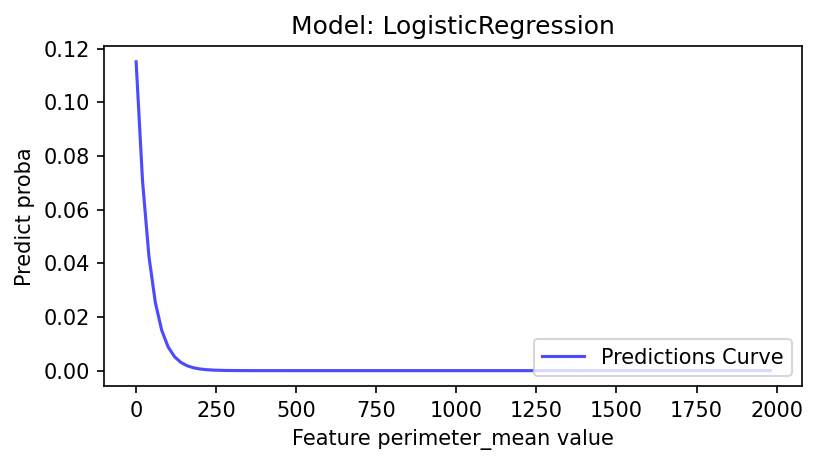

In [13]:
report_lg_ben = check_monotonicity_single_sample(model_path_lg, sample_ben, "perimeter_mean", 0,2000,20)

#### For a similar example, but from a sample of a malignant tumor, the same feature presents a monotonic behavior as well

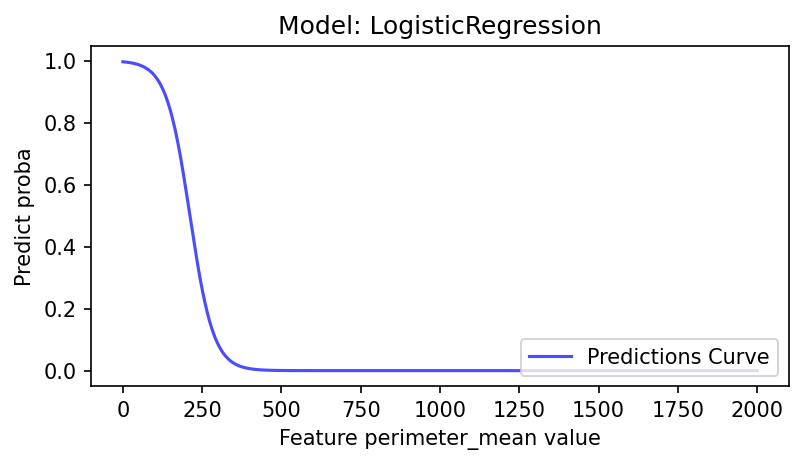

In [12]:
report_lg_mal = check_monotonicity_single_sample(model_path_lg, sample_mal, "perimeter_mean", 0,2000,1)

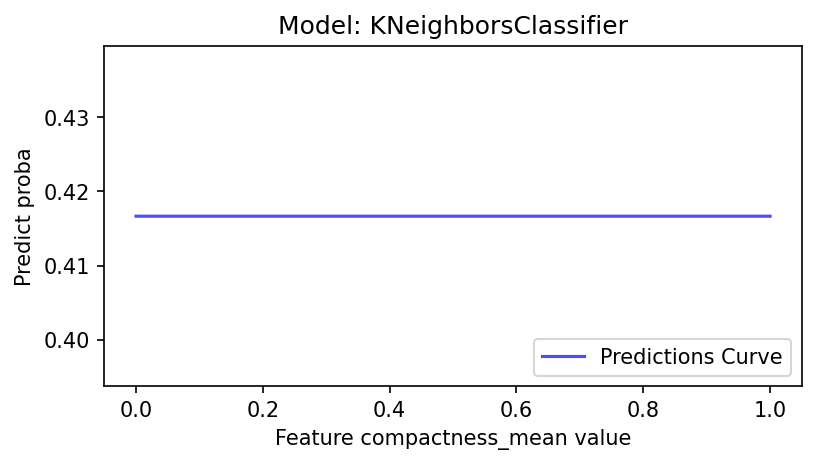

In [48]:
report_knn_ben  = check_monotonicity_single_sample(model_path_knn, sample_ben, "compactness_mean", 0,1,1)

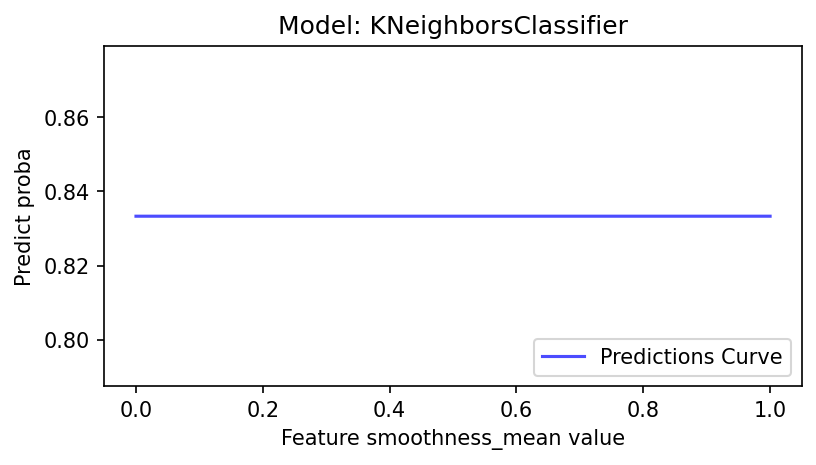

In [30]:
report_knn_mal  = check_monotonicity_single_sample(model_path_knn, sample_mal, "compactness_mean", 0,1,1)

In [ ]:
report_lg_mult_ben = check_monotonicity_multiple_samples(model_path_lg, X_ben, "perimeter_mean", 0, 10000,1)

In [ ]:
report_lg_mult_mal = check_monotonicity_multiple_samples(model_path_lg, X_mal, "perimeter_mean", 0, 10000,1)

In [ ]:
report_knn_mult_ben = check_monotonicity_multiple_samples(model_path_knn, X_ben, "perimeter_mean", 0, 10000,1)

In [ ]:
report_knn_mult_mal = check_monotonicity_multiple_samples(model_path_knn, X_mal, "perimeter_mean", 0, 10000,1)

In [ ]:
report_xg_mult_ben = check_monotonicity_multiple_samples(model_path_xg, X_ben, "perimeter_mean", 0, 10000,1)

In [ ]:
report_xg_mult_mal = check_monotonicity_multiple_samples(model_path_xg, X_mal, "perimeter_mean", 0, 10000,1)